In [3]:
import pandas as pd
import numpy as np
import spacy
import itertools
import pickle
import re
import json
import importlib

### take a look at data and save a small sample

In [126]:
train = json.load(open("./data/train-v2.0.json", "r"))["data"]

In [127]:
small_train = [i for i in train if i["title"] in ["Buddhism", "Space_Race"]]
tinny_train = []
for i in small_train:
    short_i = i
    short_i["paragraphs"] = i["paragraphs"][:3]
    tinny_train.append(short_i)

In [128]:
json.dump({"version": "v2.0", "data": tinny_train}, open("./data/tiny_train.json", "w"))

In [129]:
for title in tinny_train:
    print(title["title"])
    print("number of paragraphs:",len(title["paragraphs"]))
    for i, paragrah in enumerate(title["paragraphs"]):
        print("number of questions in paragraph {}: {}".format(i, len(paragrah["qas"])))

Buddhism
number of paragraphs: 3
number of questions in paragraph 0: 16
number of questions in paragraph 1: 10
number of questions in paragraph 2: 10
Space_Race
number of paragraphs: 3
number of questions in paragraph 0: 4
number of questions in paragraph 1: 2
number of questions in paragraph 2: 3


In [187]:
### look at dev data: clearly dev data has multiple ground truth answers, while training data has only one
dev = json.load(open("./data/dev-v2.0.json", "r"))["data"]

In [185]:
[i for i in dev if i ["title"] == "Oxygen"][0]["paragraphs"][0]["qas"][1:3]

[{'answers': [{'answer_start': 331, 'text': 'helium'},
   {'answer_start': 331, 'text': 'helium'},
   {'answer_start': 331, 'text': 'helium'},
   {'answer_start': 331, 'text': 'helium'},
   {'answer_start': 331, 'text': 'helium'}],
  'id': '571a484210f8ca1400304fbe',
  'is_impossible': False,
  'question': 'What is the second most abundant element?'},
 {'answers': [{'answer_start': 485, 'text': 'Diatomic oxygen'},
   {'answer_start': 485, 'text': 'Diatomic oxygen'},
   {'answer_start': 485, 'text': 'Diatomic oxygen gas'},
   {'answer_start': 485, 'text': 'Diatomic oxygen'},
   {'answer_start': 485, 'text': 'Diatomic oxygen gas'}],
  'id': '571a484210f8ca1400304fbf',
  'is_impossible': False,
  'question': "Which gas makes up 20.8% of the Earth's atmosphere?"}]

### Get a same small sample from v1.0

In [188]:
train1 = json.load(open("./data/train-v1.1.json", "r"))["data"]

In [189]:
small_train = [i for i in train1 if i["title"] in ["Buddhism", "Space_Race"]]
tinny_train = []
for i in small_train:
    short_i = i
    short_i["paragraphs"] = i["paragraphs"][:3]
    tinny_train.append(short_i)

In [193]:
json.dump({"version": "1.1", "data": tinny_train}, open("./data/tiny_train-v1.1.json", "w"))

### remove train and dev data that has >512 tokens
the result is a slightly smaller train and dev. less than 1% is removed

In [15]:
from transformers import DistilBertTokenizer

In [3]:
train1 = json.load(open("./data/train-v1.1.json", "r"))["data"]
dev1 = json.load(open("./data/dev-v1.1.json", "r"))["data"]

In [17]:
train_topics = [i["title"] for i in train1]
dev_topics = [i["title"] for i in dev1]
common_topics = set(train_topics).intersection(dev_topics)
print("number of training topics: {}, dev topics: {}, common topics: {}".format(
    len(train_topics), len(dev_topics), len(common_topics)))

number of training topics: 442, dev topics: 48, common topics: 0


In [66]:
t = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

i = 0
medium_train = []
for topic in train1:
    short_paragraphs = {"title": topic["title"], "paragraphs": []}
    for paragraph in topic["paragraphs"]:
        longest_q = np.argmax([len(i["question"]) for i in paragraph["qas"]])
        total = paragraph["context"] + " " + paragraph["qas"][longest_q]["question"]
        token_len = t.encode_plus(total, add_special_tokens=True, 
                                  return_tensors="pt")["input_ids"].shape[1]
        if token_len <= 500:
            short_paragraphs["paragraphs"].append(paragraph)
        else:
            i+= 1
            print(i, len(total.split(" ")))
    medium_train.append(short_paragraphs)

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


1 355


Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors


2 512


Token indices sequence length is longer than the specified maximum sequence length for this model (512 > 512). Running this sequence through the model will result in indexing errors


3 405


Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors


4 448
5 354


Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


6 426
7 372


Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


8 416


Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors


9 455
10 349


Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


11 424
12 411
13 432


Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


14 352


Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors


15 343
16 408


Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


17 444


Token indices sequence length is longer than the specified maximum sequence length for this model (651 > 512). Running this sequence through the model will result in indexing errors


18 497


Token indices sequence length is longer than the specified maximum sequence length for this model (778 > 512). Running this sequence through the model will result in indexing errors


19 543
20 336


Token indices sequence length is longer than the specified maximum sequence length for this model (867 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


21 668
22 414


Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors


23 572


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


24 168
25 139


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


26 381


Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors


27 500
28 400


Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors


29 420


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


30 405
31 460


In [89]:
# same thing to dev
i = 0
medium_dev = []
for topic in dev1:
    short_paragraphs = {"title": topic["title"], "paragraphs": []}
    for paragraph in topic["paragraphs"]:
        longest_q = np.argmax([len(i["question"]) for i in paragraph["qas"]])
        total = paragraph["context"] + " " + paragraph["qas"][longest_q]["question"]
        token_len = t.encode_plus(total, add_special_tokens=True, 
                                  return_tensors="pt")["input_ids"].shape[1]
        if token_len <= 500:
            short_paragraphs["paragraphs"].append(paragraph)
        else:
            i+= 1
            print(i, len(total.split(" ")))
    medium_dev.append(short_paragraphs)

Token indices sequence length is longer than the specified maximum sequence length for this model (634 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

1 523
2 477
3 389
4 430
5 508
6 503
7 408


Token indices sequence length is longer than the specified maximum sequence length for this model (814 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


8 562
9 651
10 476


Token indices sequence length is longer than the specified maximum sequence length for this model (743 > 512). Running this sequence through the model will result in indexing errors


11 516


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


12 324


In [92]:
json.dump({"version": "1.1", "data": medium_dev}, open("./data/medium_dev_v1.1.json", "w"))

### take a look at the distribution of number of paragraphs in topics

In [11]:
from matplotlib import pyplot as plt

In [8]:
train = json.load(open("./data/medium_train_v1.1.json", "r"))["data"]
dev = json.load(open("./data/medium_dev_v1.1.json", "r"))["data"]

In [20]:
num_paragraph = [len(i["paragraphs"]) for i in train]
pars = []
for i in train:
    pars.extend(i["paragraphs"])
num_qas = [len(i["qas"]) for i in pars]

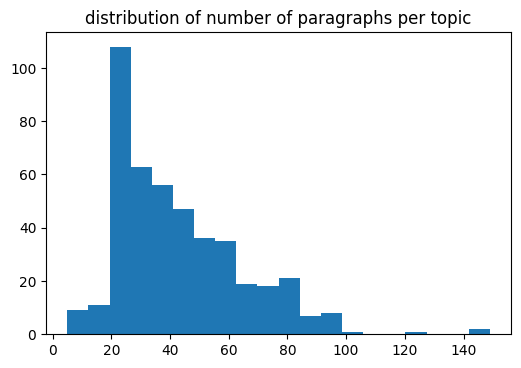

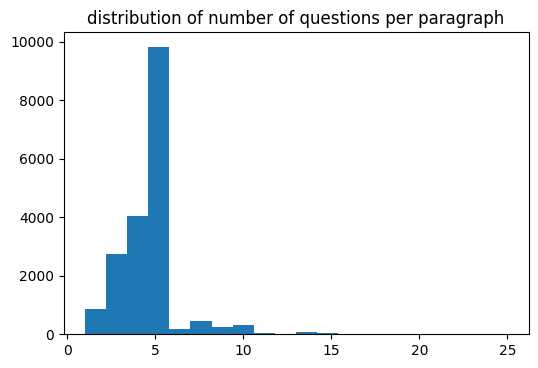

In [25]:
plt.figure(dpi=100)
plt.hist(num_paragraph, bins=20)
plt.title("distribution of number of paragraphs per topic")

plt.figure(dpi=100)
plt.hist(num_qas, bins=20)
plt.title("distribution of number of questions per paragraph")
plt.show()

In [32]:
for num_topic in [2, 5, 10, 50, 100, 200]:
    sample_train = list(np.random.choice(train, size=num_topic, replace=False))
    json.dump({"version": "1.1", "data": sample_train},
            open("./data/train{}_v1.1.json".format(num_topic), "w"))

In [37]:
for num_topic in [2, 10]:
    sample_dev = list(np.random.choice(dev, size=num_topic, replace=False))
    json.dump({"version": "1.1", "data": sample_dev},
            open("./data/dev{}_v1.1.json".format(num_topic), "w"))

In [38]:
len(dev)

48

### Test data_utils

In [130]:
importlib.reload(data_utils)
import data_utils

In [131]:
file_dict = {"train": "./data/tiny_train.json",
             "val": "./data/tiny_train.json"}

In [134]:
train_data = data_utils.prep_data(file_dict["train"])

In [147]:
len(train_data)

6

In [152]:
for batch in train_data:
    print("---Context\n"+batch.context)
    for i, (q,a) in enumerate(zip(batch.q, batch.a)):
        print("Q{}:{}".format(i, q))
        print("A{}:{}".format(i, a))
        print("id", batch.id[i])
        print("start index", batch.a_index[i])
    break

---Context
Buddhism /ˈbudɪzəm/ is a nontheistic religion[note 1] or philosophy (Sanskrit: धर्म dharma; Pali: धम्म dhamma) that encompasses a variety of traditions, beliefs and spiritual practices largely based on teachings attributed to Gautama Buddha, commonly known as the Buddha ("the awakened one"). According to Buddhist tradition, the Buddha lived and taught in the eastern part of the Indian subcontinent, present-day Nepal sometime between the 6th and 4th centuries BCE.[note 1] He is recognized by Buddhists as an awakened or enlightened teacher who shared his insights to help sentient beings end their suffering through the elimination of ignorance and craving. Buddhists believe that this is accomplished through the direct understanding and perception of dependent origination and the Four Noble Truths.
Q0:What type of religion is Buddhism?
A0:nontheistic
id 56cff91b234ae51400d9c1bb
start index 25
Q1:What are the practices of Buddhism based on?
A1:teachings attributed to Gautama Budd